# Set Up

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import types as sparktypes
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from matplotlib import gridspec

sc = SparkContext()
spark = SparkSession(sc)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reg_df = spark.read.option("header", "true").csv("/content/drive/MyDrive/College/CSC_369/data/Electric_Vehicle_Population_Data.csv")
reg_activity_df = spark.read.option("header", "true").csv("/content/drive/MyDrive/College/CSC_369/data/Electric_Vehicle_Title_and_Registration_Activity.csv")

# Introduction

I am not that interested in different types of cars, however recently I have noticed an increase in advertisements for electric vehicles. The first company that comes to mind when I think "electric vehicle" is Tesla - but should it be? After looking into the registered electric vehicles in Washington, I would say yes. There is a clear increase in number of registered electric vehicles over time and, post 2017, Tesla has been the dominate make of electric vehicle.

# Datasets

###**Electric Vehicle Population Data**


> This dataset contains Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) currently registered through the Washington State Department of Licensing as of February 17, 2023.
>
> The primary columns we will look at are:
>
>*   DOL Vehicle ID: primary key
>*   County
>*   City
>*   Postal Code: zip code
>*   Electric Vehicle Type: full electric or hybrid
>
> Source: https://catalog.data.gov/dataset/electric-vehicle-population-data



In [ ]:
reg_df.select('DOL Vehicle ID', 'County', 'City', 'Postal Code', 'Electric Vehicle Type').show(5, truncate=False)
reg_df.printSchema()

+--------------+---------+----------+-----------+--------------------------------------+
|DOL Vehicle ID|County   |City      |Postal Code|Electric Vehicle Type                 |
+--------------+---------+----------+-----------+--------------------------------------+
|153998050     |San Diego|Oceanside |92051      |Battery Electric Vehicle (BEV)        |
|138214331     |Sedgwick |Derby     |67037      |Plug-in Hybrid Electric Vehicle (PHEV)|
|3129059       |Snohomish|Marysville|98271      |Battery Electric Vehicle (BEV)        |
|166525635     |Kitsap   |Bremerton |98337      |Plug-in Hybrid Electric Vehicle (PHEV)|
|475248315     |Snohomish|Edmonds   |98026      |Battery Electric Vehicle (BEV)        |
+--------------+---------+----------+-----------+--------------------------------------+
only showing top 5 rows

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code

###**Electric Vehicle Title and Registration Activity**


> This dataset contains records of title activity (change of ownership) and registration activity (authorizing vehicles to be used in Washington) from
January 2010 through February 2023.
>
> The primary columns we will look at are:
>
>*   DOL Vehicle ID: primary key
>*   County
>*   City
>*   Postal Code: zip code
>*   Clean Alternative Fuel Vehicle Type: full electric or hybrid (same as Electric Vehicle Type from previous dataset)
>*   Make: manufacturer
>*   Model
>*   Transaction Type: registration renewal, origional registration, origional title, transfer title, registration at time of transfer
>*   Transaction Year: year record was entered into dataset
>
> Source: https://catalog.data.gov/dataset/electric-vehicle-title-and-registration-activity


In [ ]:
reg_activity_df.select('DOL Vehicle ID', 'County', 'City', 'Postal Code', 'Clean Alternative Fuel Vehicle Type', 'Make', 'Model', 'Transaction Type', 'Transaction Year').show(5, truncate=False)
reg_activity_df.printSchema()

+--------------+--------+--------+-----------+--------------------------------------+-------------+----------+---------------------+----------------+
|DOL Vehicle ID|County  |City    |Postal Code|Clean Alternative Fuel Vehicle Type   |Make         |Model     |Transaction Type     |Transaction Year|
+--------------+--------+--------+-----------+--------------------------------------+-------------+----------+---------------------+----------------+
|161666928     |King    |KIRKLAND|98034      |Plug-in Hybrid Electric Vehicle (PHEV)|TOYOTA       |RAV4 Prime|Registration Renewal |2022            |
|100195742     |Thurston|OLYMPIA |98512      |Battery Electric Vehicle (BEV)        |MERCEDES-BENZ|B-Class   |Transfer Title       |2018            |
|100195742     |Thurston|OLYMPIA |98512      |Battery Electric Vehicle (BEV)        |MERCEDES-BENZ|B-Class   |Original Registration|2015            |
|100195742     |Thurston|OLYMPIA |98512      |Battery Electric Vehicle (BEV)        |MERCEDES-BENZ|B

# Questions

*   Has there been an increase in electric vehicle ownership within the past few years?
*   What make of vehicle was the most popular each year? Within each make, was there a stand out model?
*   Are there more Full Electric or Hybrid vehicles currently registered? Do different cities favor one type over the other? Do counties? Do Postal Codes?





## Problem Decomposition
1. Has there been an increase in electric vehicle ownership within the past few years?
> We will use the vehicle registration dataset and start by filtering the results to only include vehicle registrations (and not title transfers). Then, after grouping by transaction year, we will count the number of records for each year.
>
> To further analyze the results, we can look at the change in amount of registered electric vehicles from year-to-year. To accomplish this, we can join our dataframe onto itself, where the transaction year of one equals the transaction year - 1 of the other. Then we can calculate the difference in counts from one year to the previous.
>
> In both steps, we filtered out the year recorder pertaining to 2023 since we only have data on 2 months compared to the full year of all other years.

2. What make of vehicle was the most popular each year? Within each make, was there a stand out model?
> Using the vehicle registration dataset, we once again begin by filtering the results to only include vehicle registrations. Next we group by year then make, and count the records of each make for each year. Finally, we find the max count(s) from each year. Using these results, we can perform the same steps as before, but rather than finding the max instead join the max values we found earlier and filtering our newly joined table to only include the counts which are equal to the max for each year respectivly. This will let us find the majority make of electric vehicle owned in Washington each year.
>
> To find the majority model of each make for each year, we will perform the same steps as before, with the addition of adding model to the group by statements and joining the results from before, prior to any group by's, so we are only looking at the model(s) of the majority make(s) for each year.
>
> To easily compare the counts, we joined the results of the two tables above, as well as the results from question 1, and calculated the percentage of vehicles by make and by model for each year.  

3. Are there more Full Electric or Hybrid vehicles currently registered? Do different cities favor one type over the other? Do counties? Do Postal Codes?
> First, we need to join the vehicle registration dataset to the vehicle population dataset. Since the same vehicle can appear on the registration dataset multiple times, we will order by descending transaction year, drop duplicate Vehicle Id's (which keeps the first record aka the most recent). To answer the first part of the question we can group by vehicle type and count the records for each group.
>
> The remaining questions are a bit trickier. Since it is not guaranteed that each group has at least one vehicle of every type, we need to be able to account for 0 vehicles of said type.
>
> To do this we created a dataframe of all possible cities and a dataframe of all possible types using a select statements and distinct statement for each. Then, we cross joined the two dataframes to get every combination of city and type.
>
> Now we create a dataframe counting the number of records of each type for each city (group by city then count), and join this dataframe to the cross joined dataframe using a left joined. The left join is important here so any instances of 0 type for a city have a count of NA. Next we filter out the city 'null' and replace all NA's in the count column with 0.
>
> To find the percent of full electric vehicles in each city, we join our current dataframe with itself; this creates a record for every permutation of type for each city (full, full | full, hybrid | hybrid, full | hybrid, hybrid). After filtering out all the records where both types are the same, then ordering by the type of one column and dropping duplicates, we end up with one record per city containing the counts for full electric and hybrid. Finally, we can compute the percentage of full electric vehicles in each city (out of all electric vehicles), then use a filter to only keep those with over 50% full electric vehicles. To get the percentage of cities that have over 50% full electric vehicles, we can take our dataframe containing all the cities from earlier, get the count, then divide the count of our dataframe by this count.
>
> To get the counties and postal code percentages, we can perform the same steps above, except replace city with county/postal code!

# Results

## 1. Has there been an increase in electric vehicle ownership within the past few years?

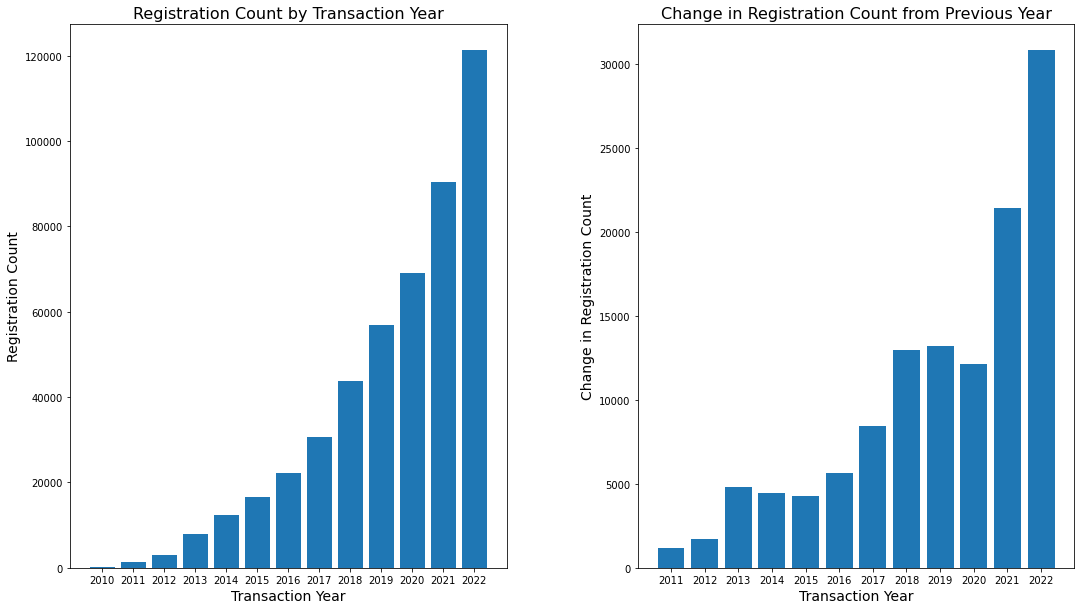

In [ ]:
reg_count = (reg_activity_df
             .filter(reg_activity_df['Transaction Type'].contains("Registration"))
             .groupBy('Transaction Year')
             .count()
             .filter(reg_activity_df['Transaction Year'] != 2023)
             .orderBy('Transaction Year'))

reg_diff = (reg_count.alias('rc1')
            .join(reg_count.alias('rc2'), col('rc1.Transaction Year') == col('rc2.Transaction Year') - 1)
            .withColumn('diff', col('rc2.count') - col('rc1.count'))
            .select('rc2.Transaction Year', 'diff')
            .filter(col('Transaction Year') != 2023)
            .orderBy('rc1.Transaction Year'))

gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1,1], wspace=0.3)
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(gs[0])
ax2 = f.add_subplot(gs[1])

reg_count_pd = reg_count.toPandas()
ax1.bar(reg_count_pd['Transaction Year'], reg_count_pd['count'])
ax1.set_xlabel('Transaction Year', fontsize = 14)
ax1.set_ylabel('Registration Count', fontsize = 14)
ax1.set_title('Registration Count by Transaction Year', fontsize = 16)

reg_diff_pd = reg_diff.toPandas()
ax2.bar(reg_diff_pd['Transaction Year'], reg_diff_pd['diff'])
ax2.set_xlabel('Transaction Year', fontsize = 14)
ax2.set_ylabel('Change in Registration Count', fontsize = 14)
ax2.set_title('Change in Registration Count from Previous Year', fontsize = 16)

f.show()

We can confidently conclude that, over time, the amount of electric vehciles registered in Washington has increased. Ignoring 2023, since we only have data for the first two monthes, each year has a larger count than all previous years.

Looking at the change in number of registered electric vehicles from year to year, overall there has been an increase in registered electric vehicles each year (which we also saw in the first plot). Additionally, we see a large increase in registered vehicles from 2017 to 2018 compared to prior years, as well as a large increase from 2020 to 2021 and 2021 to 2022 compared to prior years. This supports the conclusion that electric vehicles have been becoming more over time since a greater number of people have registered electric vehicles in more recent years.



---



## 2. What make of vehicle was the most popular each year? Within each make, was there a stand out model?

In [ ]:
max_count = (reg_activity_df
             .filter(reg_activity_df['Transaction Type'].contains("Registration"))
             .groupBy('Transaction Year', 'Make')
             .count()
             .groupBy('Transaction Year')
             .agg(F.max('count').alias('max_count')))

make_count = (reg_activity_df
             .filter(reg_activity_df['Transaction Type'].contains("Registration"))
             .groupBy('Transaction Year', 'Make')
             .count()
             .join(max_count, 'Transaction Year')
             .filter('count = max_count')
             .orderBy('Transaction Year')
             .drop('count'))

max_model_count = (reg_activity_df
                   .filter(reg_activity_df['Transaction Type'].contains("Registration"))
                   .join(make_count, ['Transaction Year', 'Make'])
                   .groupBy('Transaction Year', 'Make', 'Model')
                   .count()
                   .groupBy('Transaction Year')
                   .agg(F.max('count').alias('max_model_count')))

model_count = (reg_activity_df
                   .filter(reg_activity_df['Transaction Type'].contains("Registration"))
                   .join(make_count, ['Transaction Year', 'Make'])
                   .groupBy('Transaction Year', 'Make', 'Model')
                   .count()
                   .join(max_model_count, 'Transaction Year')
                   .filter('count = max_model_count')
                   .orderBy('Transaction Year')
                   .drop('count'))

combo_count = (make_count
               .join(model_count, ['Transaction Year', 'Make'])
               .join(reg_count, 'Transaction Year')
               .withColumn('make_count/total_count', F.round(col('max_count') / col('count') * 100, 2))
               .withColumn('model_count/make_count', F.round(col('max_model_count') / col('max_count') * 100, 2))
               .withColumn('model_count/total_count', F.round(col('max_model_count') / col('count') * 100, 2))
               .select('Transaction Year', 'Make', 'Model', 'make_count/total_count', 'model_count/make_count', 'model_count/total_count')
               .orderBy('Transaction Year'))

combo_count.show()

+----------------+------+--------+----------------------+----------------------+-----------------------+
|Transaction Year|  Make|   Model|make_count/total_count|model_count/make_count|model_count/total_count|
+----------------+------+--------+----------------------+----------------------+-----------------------+
|            2010| TESLA|Roadster|                  70.0|                 100.0|                   70.0|
|            2011|NISSAN|    Leaf|                 81.48|                 100.0|                  81.48|
|            2012|NISSAN|    Leaf|                 56.24|                 100.0|                  56.24|
|            2013|NISSAN|    Leaf|                 51.14|                 100.0|                  51.14|
|            2014|NISSAN|    Leaf|                 50.75|                 100.0|                  50.75|
|            2015|NISSAN|    Leaf|                 46.16|                 100.0|                  46.16|
|            2016|NISSAN|    Leaf|                 39.9

Summarized in the table above, Nissan was the most popular make of electric vehicle prior to 2018, where Tesla took the lead and has continued to hold it. Compared to Nissan, whos majority percentage decreased each year, Teslas majority percentage has only increased each year (setting aside 2023). A result I find suprising is 2018's majority make percentage. Only 28% of electric vehicles in Washington were made by Tesla, yet this was the majority that year. Compared to other years, this is relatively small since at least 35%, but usually over 40%, was the majority.

The majority model percentage by make tells a boring story. While Nissan was the majority model, the Nissan Leaf was the most popular (and only model of Nissan) registered electric vehicle in Washington. When Tesla took over the reigns the Tesla Model 3 was at the top. However, so far this year the Telsa Model Y is the most popular.

On the other hand, the majority model percentage by all electric vehicles in Washington look more interesting. As expected, while Nissan is the majority this percentage is equivalent to the majority make percentage. In other words, the percentage is large. But, while Tesla is the majority, the majority model percentage by all electric vehicles is much lower. This leaves us with three options: there is more competition in the electric vehicle market post 2017, the new majority make, Tesla, had a large number of different models making the majority model percentage for all electric vehicles appear small, or a combination of both.



---



## 3. Are there more Full Electric or Hybrid vehicles currently registered? Do different cities favor one type over the other? Do counties? Do Postal Codes?

In [ ]:
cur_reg = (reg_df
           .join(reg_activity_df, 'DOL Vehicle ID')
           .orderBy('Transaction Year', ascending = False)
           .dropDuplicates(['DOL Vehicle ID'])
           .select('DOL Vehicle ID', 'Transaction Year', 'Clean Alternative Fuel Vehicle Type', reg_df['City'], reg_df['County'], reg_df['Postal Code']))

type_count = (cur_reg
              .groupBy('Clean Alternative Fuel Vehicle Type')
              .count()
              .orderBy('count', ascending = False))


def get_pct(x):
  type_count = (cur_reg
                .groupBy(x, 'Clean Alternative Fuel Vehicle Type')
                .count()
                .orderBy(x))

  all_x = (cur_reg
                .select(x)
                .distinct())

  all_type = (cur_reg
              .select('Clean Alternative Fuel Vehicle Type')
              .distinct())

  all_x_type = all_x.crossJoin(all_type)

  type_count = (all_x_type
                .join(type_count, [x, 'Clean Alternative Fuel Vehicle Type'], 'left')
                .filter(all_x_type[x] != 'null')
                .fillna(0, subset=['count'])
                .orderBy(x))

  type_pct = (type_count.alias('ctc1')
               .join( type_count.alias('ctc2'), x)
               .filter(col('ctc1.Clean Alternative Fuel Vehicle Type') != col('ctc2.Clean Alternative Fuel Vehicle Type'))
               .orderBy('ctc1.Clean Alternative Fuel Vehicle Type')
               .dropDuplicates([x])
               .withColumn('full_electric_count / total_count', F.round((col('ctc1.count') / (col('ctc1.count') + col('ctc2.count'))) * 100, 2))
               .select(x, 'full_electric_count / total_count')
               .orderBy(x))

  majority_full_count_x = (type_pct
                           .filter( type_pct['full_electric_count / total_count'] > 50)
                           .count())

  print(f'Percent of Majority Full Electric Vehicle ({x}): {round(majority_full_count_x / all_x.count() * 100, 2)}%')

type_count.show(truncate = False)
for loc in ['City', 'County', 'Postal Code']:
  get_pct(loc)

+--------------------------------------+-----+
|Clean Alternative Fuel Vehicle Type   |count|
+--------------------------------------+-----+
|Battery Electric Vehicle (BEV)        |91254|
|Plug-in Hybrid Electric Vehicle (PHEV)|27361|
+--------------------------------------+-----+

Percent of Majority Full Electric Vehicle (City): 74.45%
Percent of Majority Full Electric Vehicle (County): 68.67%
Percent of Majority Full Electric Vehicle (Postal Code): 77.08%


Looking at the table above, there is a large difference of 63,893 more registered full electric vehicles than hybrid electric vehicles. Possible conclusions are that people who use electric vehicles prefer full electric, the performance to cost benefit of a full electric vehicle outweights that of a hybrid, or possibly full electric vehicles are more available than hybrid. Without further research we cannot be sure why there exists a difference.

A majority of cities, counties, and postal code areas have a majority of full electric vehicles. In other words, there is not one concentrated location which prefers full electric vehicles skewing the previous results. We can say that a people prefer full electric to hybrid, regardless of location in Washington.



---



# Conclusion

We can conclude that, over time, there has been an increase in ownership of electric vehicles in Washington; with larger increases in the past two years. From 2011 to 2017, the Nissan Leaf was the most popular vehicle, and from 2018 to present day Tesla has held the reigns. Currently full electric vehicles are the most popular compared against hybrid vehicles, regardless of location. This follows what we saw from question 2 since Tesla, a full electric vehicle manufacturer, has been the dominate make for the past few years.

Using dataframes with Pyspark was a effective tool against my questions. I not only felt the most comfortable using it, since I have experience with Pandas dataframes, but it allowed me to output my results as I coded in a clean format which helped solve issues I ran into.

A limitation due to my datasets is only being able to generalize my results to and discuss Washington. I would like to perfrom similar analysis on and including other states or even countries. This would increase the scope and reliability of the results, and may even change them as well. I would also want to look at data on different electric vehicles in an attempt to figure out why some are more popular than others. With additional information on specific vehicles and locations, results from these questions could help companies know where they should advertise, where to set up charging stations, and help legislatures make more informed policy descisions on electric vehicles.

# Cleanup

In [ ]:
sc.stop()